<p style="font-size: 22pt; color: green; font-family: 'Times New Roman';">
 Import Modules necessary for running this notebook 
</p>

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

import fun_CondProb as fn

<span style="font-family: 'Times New Roman'; font-size: 32px; color: red;"> List available FACTS Data:: <br> </span>
    

<span style="font-size: 22px; color: green;"> :: FACTS 1.1.1 run</span> 
    

In [2]:
ssp='ssp585'
# path = f'/projects/kopp/ar2208/factsv1.1.1/coupling.{ssp}/output/'
path = f'/Users/dota/werk/2022_09_FACTS/0000_facts-OPdata/amarel/ar2208/factsv1.1.1/coupling.{ssp}/output/'
files=fn.list_files_with_names(path, ["global"])
#
df = pd.DataFrame(files, columns=['File Name']).reset_index().rename(columns={'index': 'Index'})
print(df.to_string(index=False))

 Index                                                          File Name
     0            coupling.ssp585.GrIS1f.FittedISMIP.GrIS_GIS_globalsl.nc
     1           coupling.ssp585.ar5AIS.ipccar5.icesheets_AIS_globalsl.nc
     2          coupling.ssp585.ar5AIS.ipccar5.icesheets_EAIS_globalsl.nc
     3           coupling.ssp585.ar5AIS.ipccar5.icesheets_GIS_globalsl.nc
     4          coupling.ssp585.ar5AIS.ipccar5.icesheets_WAIS_globalsl.nc
     5           coupling.ssp585.ar5glaciers.ipccar5.glaciers_globalsl.nc
     6        coupling.ssp585.bamber19.bamber19.icesheets_AIS_globalsl.nc
     7       coupling.ssp585.bamber19.bamber19.icesheets_EAIS_globalsl.nc
     8        coupling.ssp585.bamber19.bamber19.icesheets_GIS_globalsl.nc
     9       coupling.ssp585.bamber19.bamber19.icesheets_WAIS_globalsl.nc
    10            coupling.ssp585.deconto21.deconto21.AIS_AIS_globalsl.nc
    11           coupling.ssp585.deconto21.deconto21.AIS_EAIS_globalsl.nc
    12           coupling.ssp585.decon

<hr style="border: none; height: 2px; background-color: none; border-style: dotted;">
<p style="font-size: 32px; color: green;">&#10145; Choose <span style="color: blue;">data</span> file.</p>

In [3]:
start_year=2020; end_year=2100; unit='cm'; station=0; region='global'
ssps = ['ssp119', 'ssp126','ssp245','ssp370', 'ssp585']

# Base path of data folder (all ssp).
base_path = '/Users/dota/werk/2022_09_FACTS/0000_facts-OPdata/amarel/ar2208/factsv1.1.1'

# Dictionary of filenames
file_names = {
    'wf1f': 'total.workflow.wf1f.{}.nc'.format(region),
    'wf2f': 'total.workflow.wf2f.{}.nc'.format(region),
    'wf3f': 'total.workflow.wf3f.{}.nc'.format(region),
    'wf4' : 'total.workflow.wf4.{}.nc'.format(region)
}

# Dictionary to store the results
all_ssp = {key: {} for key in file_names}

# Loop over each SSP scenario
for ssp in ssps:
    for key, filename in file_names.items():
        file_path = f'{base_path}/coupling.{ssp}/output/coupling.{ssp}.{filename}'
        dat, slc, time, lat, lon = fn.extract_nc_info(file_path, station, unit, start_year, end_year)
        all_ssp[key][ssp] = {'dat': dat, 'slc': slc, 'time': time, 'lat': lat, 'lon': lon, 'path': file_path, 'filename': filename}
del dat, slc, time, lat, lon, ssp, file_path, key, file_names, filename

<div style="position: relative; width: 100%;">
    <hr style="position: absolute; left: 0; width: 50%; border: none; height: 2px; background-color: yellow; border-style: dotted;">
</div>

<span style="font-family: 'Times New Roman'; font-size: 22pt; color: green;">
     :: </span> 
<span style="color: red;"> PLOT </span>

In [4]:

# ssps=ssps; comp='wf1f'; data_=all_ssp; years_=[2030,2050,2070,2090, 2100]
# fn.PLOT_samps(ssps,comp,data_,years_,color='r')

<hr style="border: none; height: 2px; background-color: none; border-style: dotted;">
<span style="font-family: 'Times New Roman'; font-size: 22pt; color: green;">
     sklearn KDE
</span>
<br>
<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    Visualize the data like in 
    <a href=" https://doi.org/10.1029/2019JF005418"><b>Gilford20</b></a>
    Figure_4b  
</span>

<p>Approach — </p>
<ol>
    <li>Use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html">sklearn.neighbors.KernelDensity</a> to fit a 2-d kernel density estimate to the pairs of, for example, (2030, 2100) in a <code> 2D matrix</code>.</li>
    <li>Create a grid of test points. Based on the <code>max/min</code> of each column, create a meshgrid <code> grid_samples</code>.</li>
    <li>Use the <code>score_samples</code> method of the kernel density estimate to determine a weight for each test point.<br><code>log_density_values = kde.score_samples(grid_samples)</code></li>
    <li>Convert it to density <code>expo(log_density_values)</code>
    <li>Normalize the weights column wise. <i>Divide individual column value by column sum.</i></li>
    <li>Convert back to log values. </li>
    <li>Do a filled contour plot as in Gilford20.<br>
</ol>


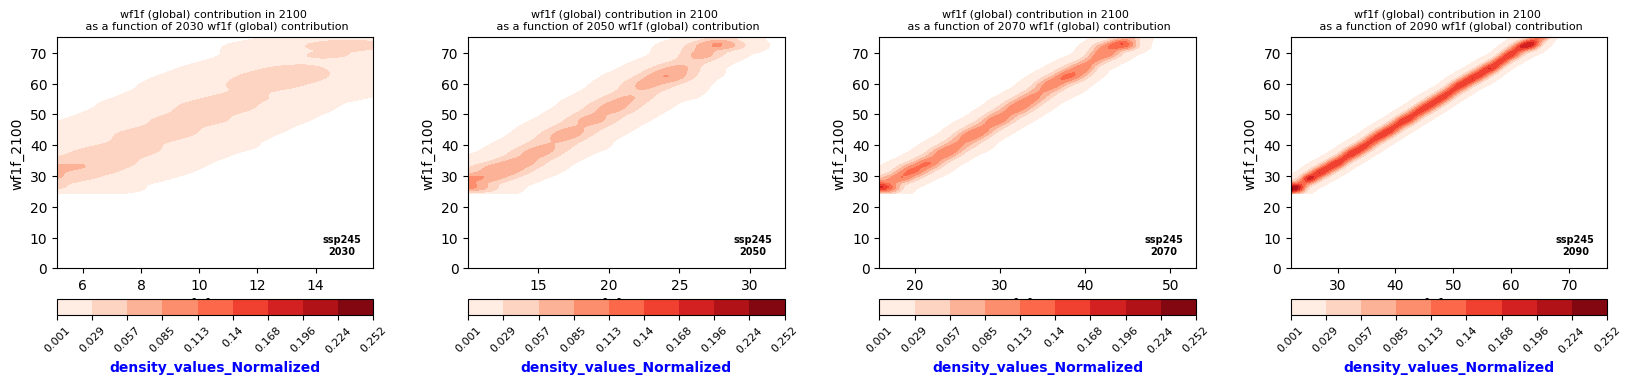

In [5]:
# Function for plotting
def plot_gilford(ax, var1, t1, t2, ssp, k, bw, linspace_int, scatter, cmap, plotOPT):
    # AXIS variables
    xaxVAR = var1['slc'][:, np.where(var1['time']==t1)[0][0]] 
    yaxVAR = var1['slc'][:, np.where(var1['time']==t2)[0][0]] 
    # LABELS
    fileNAME = var1['filename'].split('.')[2]
    xaxLAB = f"{fileNAME}_{t1}";  
    yaxLAB = f"{fileNAME}_{t2}"
    title = f"{fileNAME} ({region}) contribution in {t2} \n as a function of {t1} {fileNAME} ({region}) contribution"
    # PLOT
    fn.gilford(ax, xaxVAR, yaxVAR, k, bw, linspace_int, 'density_values_Normalized', xaxLAB, yaxLAB, title, ssp, scatter, cmap, t1, plotOPT)

ssp='ssp245'
var1 = all_ssp['wf1f'][ssp]

#_-_-_-_-_-_-  Set up the figure and axes
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
#
# Common parameters
k = 'gaussian'; bw = 1; linspace_int = 100; scatter = 'NO'; cmap = 'Reds'
years = [2030, 2050, 2070, 2090]; t2 = 2100
#
plotOPT = {'y_ax_min': 0, 'y_ax_max': 75,
           'c_bar_min': 0.001, 'c_bar_max': 0.252, 'plotCBAR' : 'YES'}
#
# Loop to create plots
for i, t1 in enumerate(years):
    plot_gilford(ax[i], var1, t1, t2,ssp, k, bw, linspace_int, scatter, cmap, plotOPT)


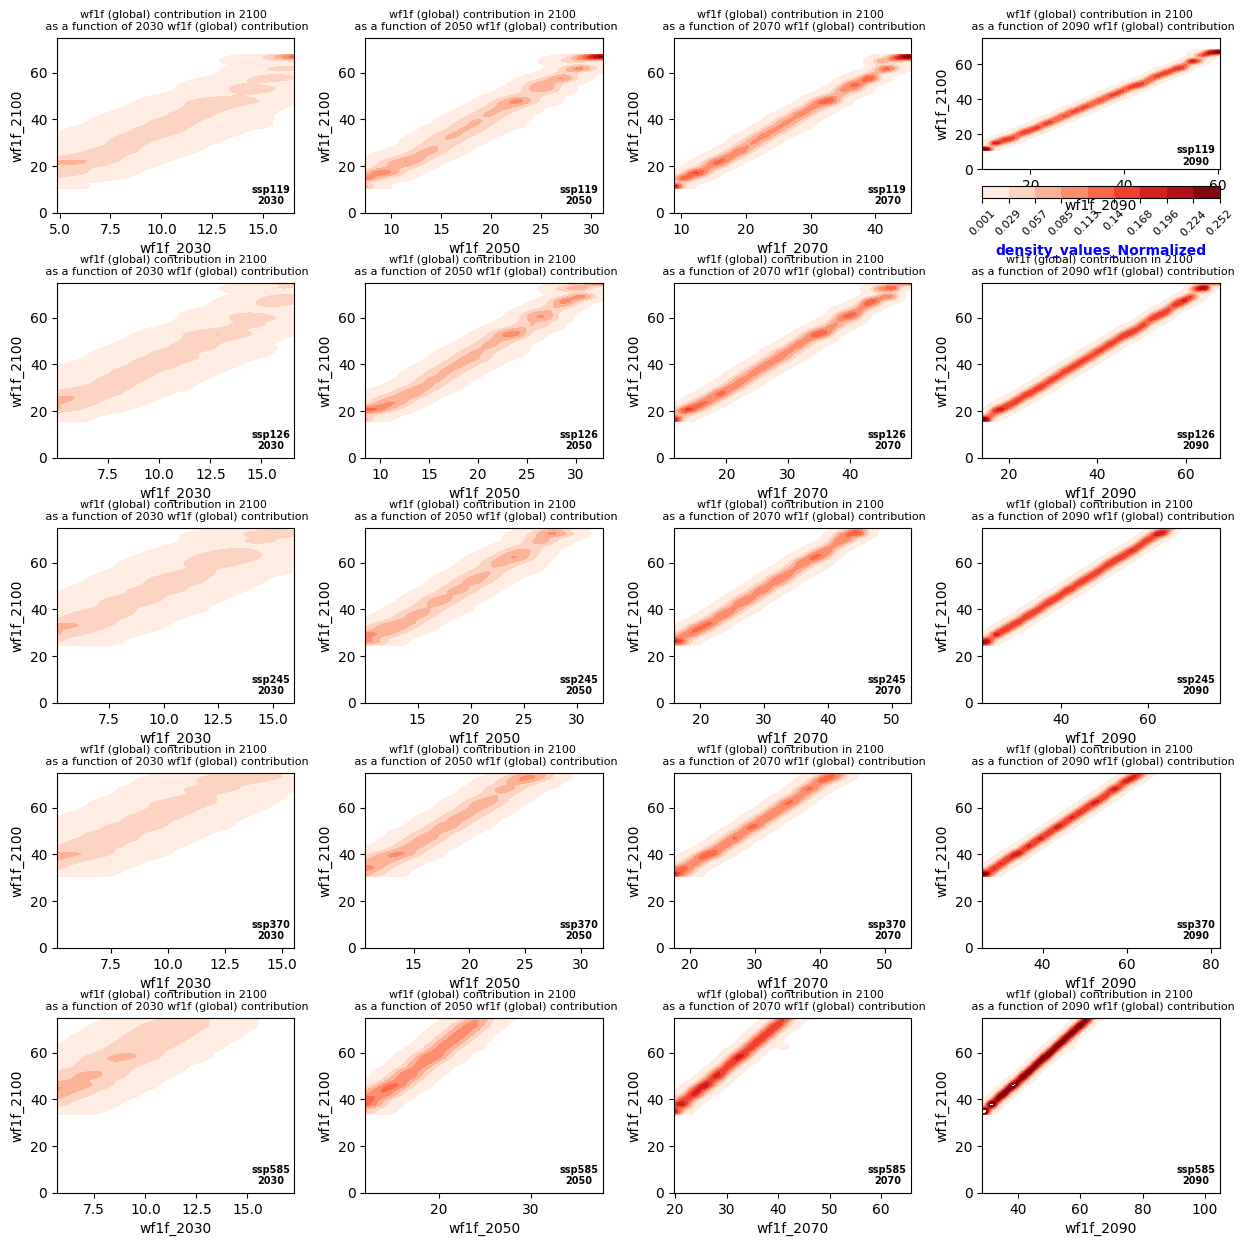

In [6]:
# Function for plotting
def plot_gilford(ax, var1, t1, t2, ssp, k, bw, linspace_int, scatter, cmap, plotOPT):
    # AXIS variables
    xaxVAR = var1['slc'][:, np.where(var1['time']==t1)[0][0]] 
    yaxVAR = var1['slc'][:, np.where(var1['time']==t2)[0][0]] 
    # LABELS
    fileNAME = var1['filename'].split('.')[2]
    xaxLAB = f"{fileNAME}_{t1}";  
    yaxLAB = f"{fileNAME}_{t2}"
    title = f"{fileNAME} ({region}) contribution in {t2} \n as a function of {t1} {fileNAME} ({region}) contribution"
    # PLOT
    fn.gilford(ax, xaxVAR, yaxVAR, k, bw, linspace_int, 'density_values_Normalized', xaxLAB, yaxLAB, title, ssp, scatter, cmap, t1, plotOPT)


#_-_-_-_-_-_-  Set up the figure and axes
fig, ax = plt.subplots(5, 4, figsize=(15, 15))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
#_-_-_-_-_-_- Common parameters
k = 'gaussian'; bw = 1; linspace_int = 100; scatter = 'NO'; cmap = 'Reds'
years = [2030, 2050, 2070, 2090]; t2 = 2100
#
#
for s1,ssp in enumerate(ssps):
    # 
    for i, t1 in enumerate(years):
        #
        if s1==0 and i==3:
            plotOPT = {'y_ax_min': 0, 'y_ax_max': 75,
                       'c_bar_min': 0.001, 'c_bar_max': 0.252, 'plotCBAR' : 'YES'}
        else:
            plotOPT = {'y_ax_min': 0, 'y_ax_max': 75,
                       'c_bar_min': 0.001, 'c_bar_max': 0.252, 'plotCBAR' : 'NO'}
            
        plot_gilford(ax[s1,i], all_ssp['wf1f'][ssp], t1, t2,ssp, k, bw, linspace_int, scatter, cmap, plotOPT)


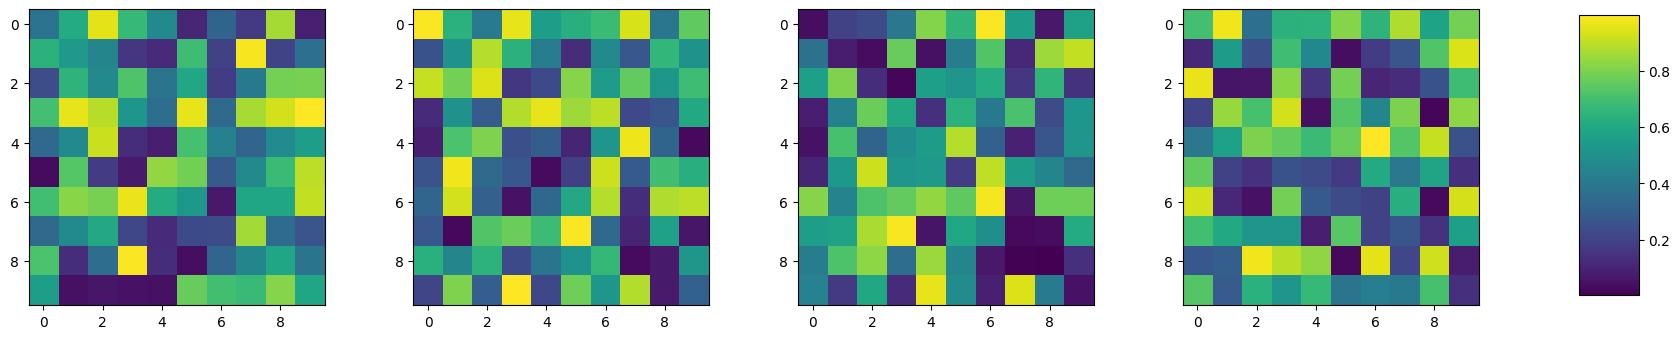

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure and axes
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
fig.subplots_adjust(wspace=0.3, hspace=0.4, right=0.85)

# Example data and plotting commands
data = [np.random.rand(10, 10) for _ in range(4)]
vmin = min(datum.min() for datum in data)  # Minimum value for the color scale
vmax = max(datum.max() for datum in data)  # Maximum value for the color scale

# Create a list to hold the imaged objects
ims = []

for i, ax in enumerate(axs):
    # Replace this with your actual plotting code
    im = ax.imshow(data[i], vmin=vmin, vmax=vmax)
    ims.append(im)

# Create a colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])  # Adjust these values as needed for your layout
fig.colorbar(ims[0], cax=cbar_ax)

plt.show()


<p>Links — </p>
 <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html\">sklearn.neighbors.KernelDensity</a>
 <br>
<a href="https://scikit-learn.org/stable/modules/density.html#kernel-density-estimation\"> kernel-density-estimation</a>

<hr style="border: none; height: 2px; background-color: none; border-style: dotted;">

<span style="font-family: 'Times New Roman'; font-size: 22pt; color: green;">
    Bayesian Paper Figure
</span>
<br>
<span style="font-family: 'Times New Roman'; font-size: 16pt; color: green;">
     NOTES:: Last meeting was on Nov27 2023
</span>
<br><br>
<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    I presented the 
    <a href="https://raw.githack.com/pkjr002/facts/feature/NZ-rerun/JupNbk/000_pk-JupNb_TESTspace/Bayesian_cal_wg/Conditional_Probability/_print/20231127_1248_CondProb_notebook_2_AIS-BayesianCal_WG_figv1_.html">
        normalized density plot
    </a>
    <br>
    COMMENTS BELOW
</span>

In [26]:
ssps = ['ssp119', 'ssp126','ssp245','ssp370', 'ssp585']
#
station=0; 
#
start_year=2020; end_year=2100; unit='cm'; 
#
# Base path of data folder (all ssp).
base_path = '/Users/dota/werk/2022_09_FACTS/0000_facts-OPdata/amarel/ar2208/factsv1.1.1'
#
# Dictionary of filenames
file_names = {
    'wf1f_G': 'total.workflow.wf1f.global.nc',
    'wf1f_L': 'total.workflow.wf1f.local.nc',
    'wf2f_G': 'total.workflow.wf2f.global.nc',
    'wf2f_L': 'total.workflow.wf2f.local.nc',
    'TE_G'  : 'ocean.tlm.sterodynamics_globalsl.nc',
    'TE_L'  : 'ocean.tlm.sterodynamics_localsl.nc',
    'AIS_G' : 'larmip.larmip.AIS_globalsl.nc',
    'AIS_L' : 'larmip.larmip.AIS_localsl.nc'
}
#
# Dictionary to store the results
all_ssp = {key: {} for key in file_names}

# Loop over each SSP scenario
for ssp in ssps:
    for key, filename in file_names.items():
        file_path = f'{base_path}/coupling.{ssp}/output/coupling.{ssp}.{filename}'
        dat, slc, time, lat, lon = fn.extract_nc_info(file_path, station, unit, start_year, end_year)
        all_ssp[key][ssp] = {'dat': dat, 'slc': slc, 'time': time, 'lat': lat, 'lon': lon, 'path': file_path, 'filename': filename}
del dat, slc, time, lat, lon, ssp, file_path, key, file_names, filename

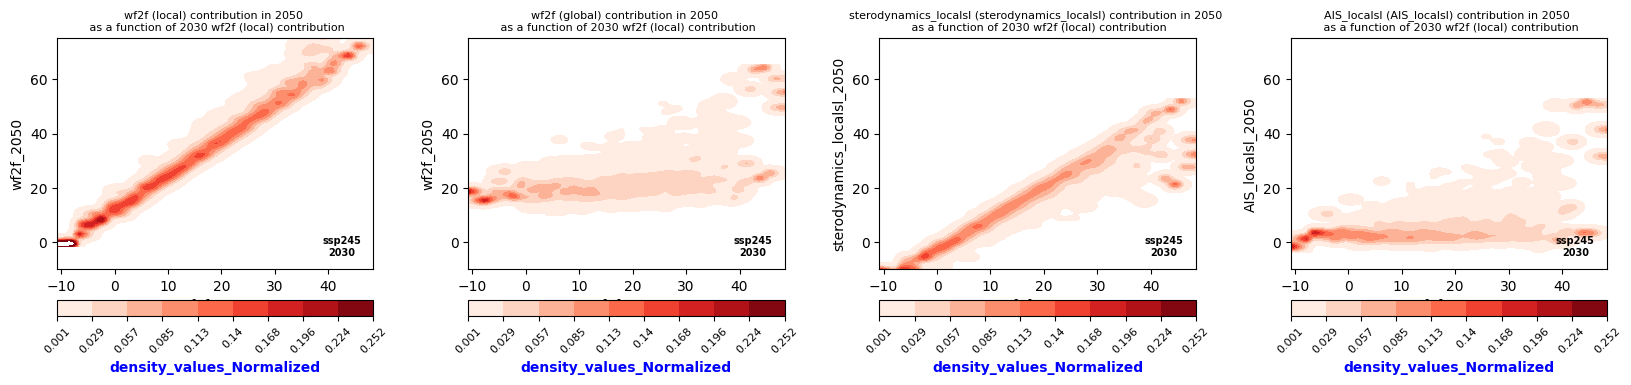

In [45]:
plot_params = {
    0: {'var1': all_ssp['wf2f_L'], 't1': 2030, 'var2': all_ssp['wf2f_L'], 't2': 2050},
    1: {'var1': all_ssp['wf2f_L'], 't1': 2030, 'var2': all_ssp['wf2f_G'], 't2': 2050},
    2: {'var1': all_ssp['wf2f_L'], 't1': 2030, 'var2': all_ssp['TE_L'], 't2': 2050},
    3: {'var1': all_ssp['wf2f_L'], 't1': 2030, 'var2': all_ssp['AIS_L'], 't2': 2050}
}

# Set up the figure and axes for 2-panel subplot
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
fig.subplots_adjust(wspace=0.3, hspace=0.4)

# Loop through the dictionary and plot
for i, params in plot_params.items():
    fn.plot_ConditionalProb(ax[i], params['var1'], params['var2'], params['t1'], params['t2'])

plt.show()


<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    2050 NYC projections conditional on
</span>
<ol style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    <li>2030 NYC observations</li>
</ol>

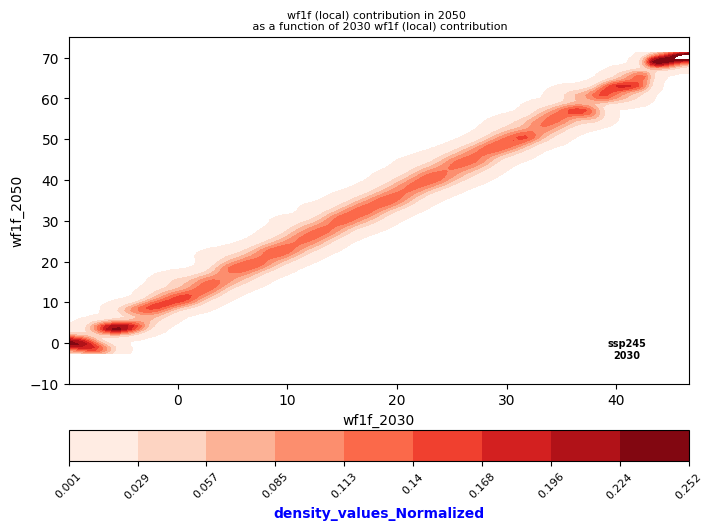

In [27]:
#_-_-_-_-_-_-  DATA
var1 = all_ssp['wf2f_L'];      t1 = 2030;
var2 = all_ssp['wf2f_L'];      t2 = 2050;
#_-_-_-_-_-_-  Set up the figure and axes
fig = plt.figure(figsize=(8, 6));  ax = plt.gca()
fn.plot_ConditionalProb(ax, var1,var2, t1, t2)

<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    2050 NYC projections conditional on
</span>
<ol style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;" start="2">
    <li>2030 GMSL observations</li>
</ol>

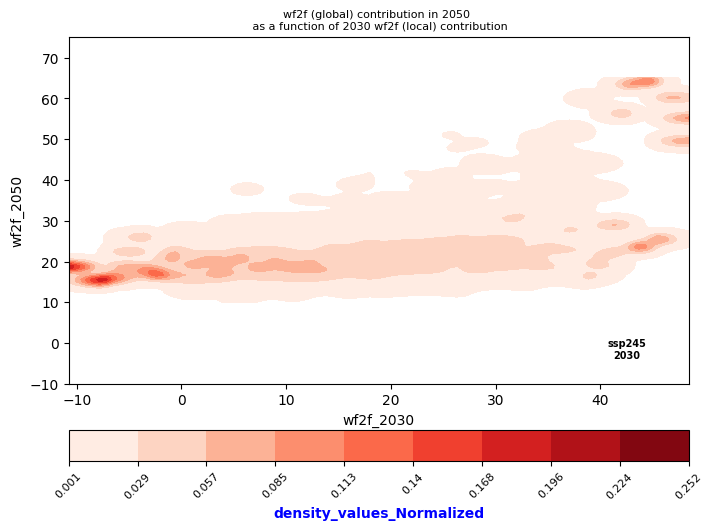

In [29]:
#_-_-_-_-_-_-  DATA
var1 = all_ssp['wf2f_L'];      t1 = 2030;
var2 = all_ssp['wf2f_G'];      t2 = 2050;
#_-_-_-_-_-_-  Set up the figure and axes
fig = plt.figure(figsize=(8, 6));  ax = plt.gca()
fn.plot_ConditionalProb(ax, var1,var2, t1, t2)

<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    2050 NYC projections conditional on
</span>
<ol style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;" start="3">
    <li>2030 thermal expansion observations</li>
</ol>

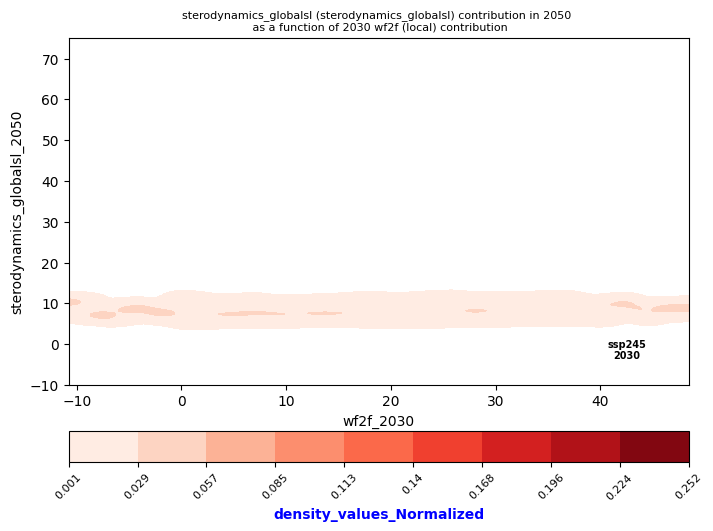

In [30]:
#_-_-_-_-_-_-  DATA
var1 = all_ssp['wf2f_L'];      t1 = 2030;
var2 = all_ssp['TE_G'];      t2 = 2050;
#_-_-_-_-_-_-  Set up the figure and axes
fig = plt.figure(figsize=(8, 6));  ax = plt.gca()
fn.plot_ConditionalProb(ax, var1,var2, t1, t2)

<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    2050 NYC projections conditional on
</span>
<ol style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;" start="4">
    <li>2030 AIS </li>
</ol>

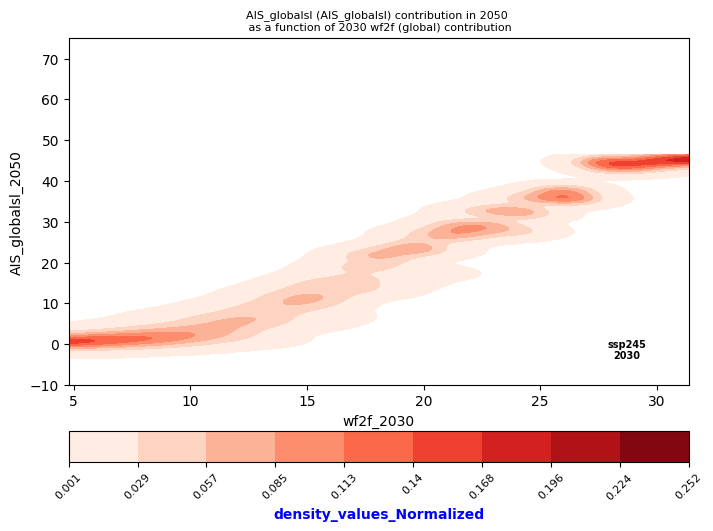

In [31]:
#_-_-_-_-_-_-  DATA
var1 = all_ssp['wf2f_G'];      t1 = 2030;
var2 = all_ssp['AIS_G'];      t2 = 2050;
#_-_-_-_-_-_-  Set up the figure and axes
fig = plt.figure(figsize=(8, 6));  ax = plt.gca()
fn.plot_ConditionalProb(ax, var1,var2, t1, t2)

<hr style="border: none; height: 2px; background-color: none; border-style: dotted;">
<span style="font-family: 'Times New Roman'; font-size: 22pt; color: green;">
    Bayesian Paper Figure list
</span>
<br><br><br>
<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    2050 NYC projections conditional on
</span>
<ol style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    <li>2030 RSL observations</li>
    <li>2030 GMSL observations</li>
    <li>2030 global mean thermal expansion observations</li>
    <li>2030 AIS observation</li>
    <li>additional time (2100, 2150)</li>
    <li>Overlay samples along with box and whisker plot onto the normalized density plot</li>
</ol>